In [1]:
!pip install jiwer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [3]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)


2748572632/2748572632 [==============================] - 37s 0us/step


In [4]:
wave_Path = data_path+'/wavs/'
metadata_Path = data_path+"/metadata.csv"

In [5]:

import csv

meta_df = pd.read_csv(metadata_Path, sep="|", header=None, quoting=3)

In [6]:
meta_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [7]:

# Assuming meta_df is your DataFrame
columns_to_remove = [1]
meta_df = meta_df.drop(columns=columns_to_remove)

In [8]:
# Renaming the columns of the DataFrame to "file_name" and "normalized_transcription"
meta_df.columns=["file_name","normalized_transcription"]

# Randomly shuffling the total rows(frac = 1) of the DataFrame and resetting the index to new
meta_df = meta_df.sample(frac=1).reset_index(drop=True)

meta_df.head(3)

,file_name,normalized_transcription
0,LJ004-0078,"""The convicted delinquent has his rights,"" sai..."
1,LJ042-0240,he continued to be interested in that country ...
2,LJ034-0151,of what he said on November twenty-two.


In [9]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_df, test_df = train_test_split(meta_df, test_size=0.1, random_state=42)

In [10]:
# Display the first 3 rows of the training set
print("Training set:")
print(train_df.head(3))

# Display the first 3 rows of the test set
print("\nTest set:")
print(test_df.head(3))

Training set:
       file_name                           normalized_transcription
2673  LJ031-0069  Dr. Clark noted some electrical activity on th...
8233  LJ014-0089  For the remainder of that week and part of the...
9681  LJ048-0230             and by a Secret Service investigation.

Test set:
       file_name                           normalized_transcription
4347  LJ012-0210  The porter received it, but from its freshness...
7732  LJ004-0232  Ironing it will be remembered, was a distingui...
3545  LJ042-0092  No evidence has been found that they used him ...


In [11]:
print(len(train_df))
print(len(test_df))


11790
1310


In [12]:
# Line 1: Create a list of characters, including lowercase letters, commas, question marks, exclamation marks, and space.
characters = [x for x in 'abcdefghijklmnopqrstuvwxyz,?! ']

# Line 3: Create a StringLookup layer mapping characters to numeric indices, with the ability to handle out-of-vocabulary (oov) tokens.
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

#Line 5: Create another StringLookup layer to map numeric indices back to characters, using the vocabulary from the char_to_num layer.
# This layer also has the ability to handle out-of-vocabulary (oov) tokens and is set to invert the mapping (numeric to character).
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)


print(f"the vocab is: {char_to_num.get_vocabulary()}"
       f"(size: {char_to_num.vocabulary_size()})"  )

the vocab is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ',', '?', '!', ' '](size: 31)


In [13]:
frame_length = 256
frame_step = 160
fft_length = 384

In [14]:
def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wave_Path+wav_file+'.wav')

    audio, _ = tf.audio.decode_wav(file)

    audio = tf.squeeze(audio, axis = -1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(audio, frame_length = frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.math.pow(spectrogram,0.5)

    means  = tf.math.reduce_mean(spectrogram,1, keepdims=True)
    stddev = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram -means)/(stddev + 1e-10)

    label = tf.strings.lower(label)

    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    label = char_to_num(label)

    return spectrogram, label

In [15]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df['file_name']), list(train_df['normalized_transcription'])))

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
    )

test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(test_df['file_name']), list(test_df['normalized_transcription']))
    )

test_dataset = (
    test_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE))

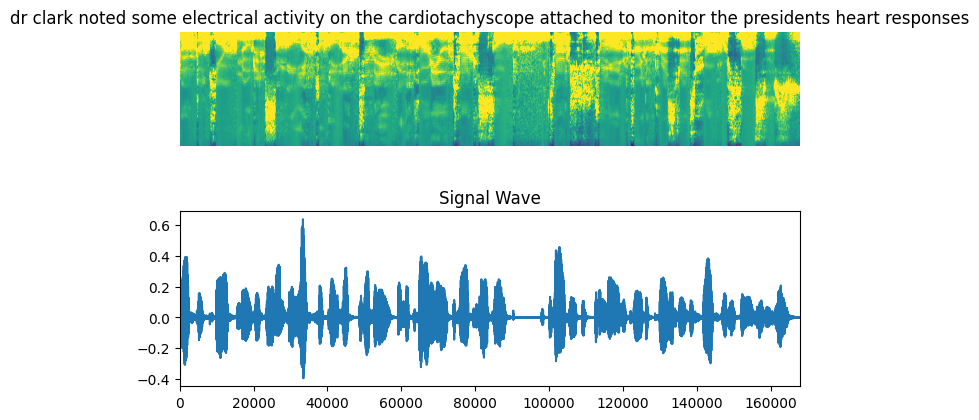

In [16]:
fig = plt.figure(figsize=(8, 5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")


    file = tf.io.read_file(wave_Path + list(train_df["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()

    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

In [17]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

    return loss


In [18]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input_spectrogram")

    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1"
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2"
    )(x)

    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNN layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN Layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
            )
        x = layers.Bidirectional(
                recurrent,name = f"bidirectional_{i}", merge_mode = "concat"
        )(x)

        # Add dropout if it's not the last layer
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense layer 1
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)  # Assuming you are using sparse categorical crossentropy

    return model

In [19]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1 ,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input_spectrogram (InputLayer)                  [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [20]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text=[]
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [21]:
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        targets = []

        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)

            for label in y:
                label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                targets.append(label)

        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)

        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target: {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)



In [ ]:
epochs = 30

validation_callback = CallbackEval(test_dataset)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/30
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target: the keeper and his officers resided at a distance from the jail, and left its inmates to their own devices
Prediction: 
----------------------------------------------------------------------------------------------------
Target: the fbi is the major domestic investigating agency of the united states,
Prediction: 
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 2004s 5s/step - loss: 308.6555 - val_loss: 283.1970
Epoch 2/30
1/1 [==============================] - 1s 626ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8961
-----

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in test_dataset:
  X, y = batch
  batch_predictions = model.predict(X)
  batch_predictions = decode_batch_predictions(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    targets.append(label)
wer_score = wer(targets, predictions)
print("-"*100)
print (f"Word Error Rate: {wer_score:.4f}")
print("-"*100)
for i in np.random.randint(0, len(predictions), 5):
  print(f"Target : {targets[i]}")
  print(f"Prediction: {predictions[i]}")
  print("-" *100)